In [5]:
# code taken from source https://www.kaggle.com/code/derinrobert/newsclassification-using-lstm-val-acc-72

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
pd.set_option('display.max_colwidth', -1)

<ipython-input-5-956378644f90>:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_json('drive/MyDrive/input/News_Category_Dataset_v3.json',lines=True)
beforeMay2018 = df[pd.to_datetime(df["date"]).dt.strftime('%Y-%m-%d')<="2019-01-31"]

required_columns = ["BLACK VOICES",
                    "COMEDY",
                    "CRIME",
                    "DIVORCE",
                    "GREEN",
                    "HOME & LIVING",
                    "IMPACT",
                    "MEDIA",
                    "PARENTS",
                    "RELIGION",
                    "SPORTS",
                    "STYLE",
                    "THE WORLDPOST",
                    "WEDDINGS",
                    "WEIRD NEWS",
                    "WOMEN",
                    "WORLD NEWS",
                    "WORLDPOST"]
df = df[df["date"] < "2018-05-26"]
df = df[df["category"].isin(required_columns)]

df.drop(['authors', 'link', 'date'], axis = 1, inplace = True)

df.head()

,headline,category,short_description
8697,North Korea Still Open To Talks After Trump Cancels Summit,WORLD NEWS,Trump’s announcement came after repeated threats by North Korea to pull out of the summit over what it saw as confrontational remarks by U.S. officials.
8698,"2 Men Detonate Bomb Inside Indian Restaurant Near Toronto, Authorities Say",WORLD NEWS,"Fifteen people were taken to the hospital, three of them with critical injuries."
8699,Thousands Travel Home To Ireland To Vote On Abortion Access,WORLD NEWS,Just try to read these #HomeToVote tweets without crying.
8700,"Irish Voters Set To Liberalize Abortion Laws In Landslide, Exit Poll Signals",WORLD NEWS,Vote counting will begin Saturday.
8701,Warriors Coach Steve Kerr Calls NFL Ban On Protests 'Fake Patriotism',BLACK VOICES,"Forbidding players to take a knee during the national anthem is “idiotic,” the coach said."


In [8]:
print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 18 categories now


COMEDY           5175
SPORTS           4884
BLACK VOICES     4528
HOME & LIVING    4195
PARENTS          3955
THE WORLDPOST    3664
WEDDINGS         3651
WOMEN            3490
IMPACT           3458
DIVORCE          3426
CRIME            3404
MEDIA            2815
WEIRD NEWS       2668
GREEN            2622
WORLDPOST        2579
RELIGION         2556
STYLE            2254
WORLD NEWS       2176
Name: category, dtype: int64

In [9]:
#from https://www.kaggle.com/code/dima806/news-category-classification-distilbert

item0 = df.shape[0]  # Store the initial number of items in the DataFrame
df = df.drop_duplicates()  # Remove duplicate rows from the DataFrame
item1 = df.shape[0]  # Store the number of items in the DataFrame after removing duplicates
print(f"There are {item0-item1} duplicates found in the dataset")  # Print the number of duplicates removed

df = df.rename(columns={'category': 'label'})  # Rename the 'category' column to 'label'

df['title'] = df['headline'] + ' ' + df['short_description']  # Create a new 'title' column by combining 'headline' and 'short_description'

df = df[['label', 'title']]  # Select only the 'label' and 'title' columns
df = df[~df['title'].isnull()]  # Remove rows where 'title' is null
df = df[~df['label'].isnull()]  # Remove rows where 'label' is null

print(df.shape)  # Print the shape of the DataFrame after data preprocessing
df.sample(5).T  # Display a random sample of 5 rows from the DataFrame

There are 218 duplicates found in the dataset
(61282, 2)


,38636,151838,44104,58043,88561
label,THE WORLDPOST,HOME & LIVING,COMEDY,IMPACT,MEDIA
title,Russia Bans 'Extremist' Image Of Putin In Makeup The government says the picture suggests the Russian president is gay.,"Soft Cabinets Made With Rubber Foam Look More Like Cartoons Than Furniture (PHOTOS) When you think of a china cabinet, you're probably imagining the heavy walnut hutch from your grandma's dining room. Well","Trevor Noah: 'America Already Invades Mexico -- Every Spring Break' “They’re bringing drugs. They’re bringing crime. They’re rapists, and some, I assume, are good people.”",Tokyo Might Make Medals For 2020 Olympics Out Of Old Cell Phones This is pure gold.,"Donald Trump Responds To Question From A Birther By Demonstrating That He Is Still A Birther A man asked him ""when can we get rid of"" Muslims?"


In [10]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('punkt')
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import gensim
from gensim.models import Word2Vec

In [11]:
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 1.2 MB/s eta 0:00:00


In [13]:
import neattext.functions as nfx
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
tknzr = nltk.tokenize

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tknzr.word_tokenize(text)]

corpus = df['title'].astype(str)
corpus = corpus.apply(nfx.remove_stopwords)
corpus = corpus.apply(nfx.remove_special_characters)
corpus = corpus.apply(nfx.remove_multiple_spaces)
corpus = corpus.str.lower()
corpus = corpus.apply(lemmatize_text)

df['title'] = corpus

[nltk_data] Downloading package wordnet to /root/nltk_data...


LookupError: ignored

## Data Tidying

In [14]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

In [15]:
df.head()

,label,title
0,GREEN,"When Our Responses to Drought Make Things Worse Water problems are a complex mix of natural resource, technology, social, economic and political conditions. When water is limited during extreme events such as droughts, society puts in place a variety of responses. But many of the actions taken in recent years have actually increased the vulnerability of other systems."
1,SPORTS,Antonio Cromartie Shuts Down Coach's Son For Making Fun Of Him On Twitter Never a good idea to make fun of an NFL player if you're the coach's son.
2,WEDDINGS,"3 Steps To Creating A Couple's Bucket List Unlike items on our most common to-do list — buy milk, pay bills, etc — it's easy to defer our relationship bucket list (and"
3,WORLDPOST,10 Powerful Photos From The Day That Morsi Fell From Power
4,BLACK VOICES,The Congressional Black Caucus Must Reject Trump's Photo-Op Meetings The CBC has the challenge of its political lifetime in confronting the Trump rein in the Oval Office.


# Tokenizing and Padding

In [16]:
X,Y = df['title'],df['label']

#80% to train , 10% for validation , 10% for testing
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state=42)

In [17]:
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [18]:
from gensim.models.keyedvectors import KeyedVectors
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

word_vectors = KeyedVectors.load_word2vec_format('drive/MyDrive/input/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [24]:



tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
num_tokens = len(tokenizer.word_index.items()) + 2
vocabulary_size = min(len(word_index)+1, num_tokens)


EMBEDDING_DIM = 300




X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)




(49025, 300)
(49025, 18)
(6128, 300)
(6128, 18)


In [25]:


embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=num_tokens:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)


embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=False)

# Model Training

In [26]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

tf.keras.backend.clear_session()

embed_size = 300

model = keras.models.Sequential([

      embedding_layer,
        keras.layers.Bidirectional(keras.layers.LSTM(256, dropout = 0.4)),
        keras.layers.Dense(18, activation="softmax")

        ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         16884900  
                                                                 
 bidirectional (Bidirection  (None, 512)               1140736   
 al)                                                             
                                                                 
 dense (Dense)               (None, 18)                9234      
                                                                 
Total params: 18034870 (68.80 MB)
Trainable params: 1149970 (4.39 MB)
Non-trainable params: 16884900 (64.41 MB)
_________________________________________________________________


In [27]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(train_set,train_label,
                     batch_size = 32,
                     steps_per_epoch=len(X_train) // 32,
                     validation_data = (val_set , val_label),
                     validation_steps = len(val_set)//32, epochs=20,
                     callbacks= early_stop)

Epoch 1/20
1532/1532 [==============================] - 77s 40ms/step - loss: 1.5894 - accuracy: 0.5028 - val_loss: 1.2410 - val_accuracy: 0.6186
Epoch 2/20
1532/1532 [==============================] - 62s 41ms/step - loss: 1.1847 - accuracy: 0.6256 - val_loss: 1.0935 - val_accuracy: 0.6561
Epoch 3/20
1532/1532 [==============================] - 62s 41ms/step - loss: 1.0552 - accuracy: 0.6616 - val_loss: 1.0197 - val_accuracy: 0.6752
Epoch 4/20
1532/1532 [==============================] - 62s 40ms/step - loss: 0.9641 - accuracy: 0.6880 - val_loss: 0.9942 - val_accuracy: 0.6814
Epoch 5/20
1532/1532 [==============================] - 62s 41ms/step - loss: 0.8861 - accuracy: 0.7107 - val_loss: 0.9838 - val_accuracy: 0.6841
Epoch 6/20
1532/1532 [==============================] - 64s 42ms/step - loss: 0.8210 - accuracy: 0.7291 - val_loss: 0.9703 - val_accuracy: 0.6991
Epoch 7/20
1532/1532 [==============================] - 64s 42ms/step - loss: 0.7531 - accuracy: 0.7510 - val_loss: 0.9986 -

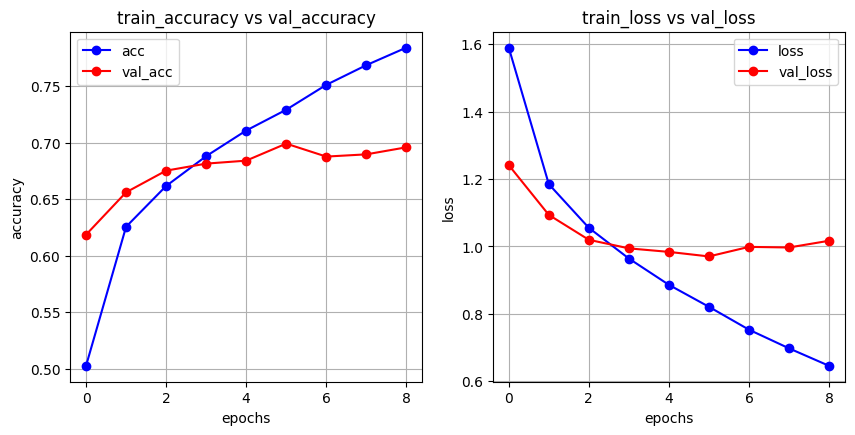

In [28]:
fig = plt.figure(figsize=(10,10))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'],'bo-', label = "acc")
plt.plot(history.history['val_accuracy'], 'ro-', label = "val_acc")
plt.title("train_accuracy vs val_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'],'bo-', label = "loss")
plt.plot(history.history['val_loss'], 'ro-', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.grid(True)
plt.legend()


# Evaluating and Making Predictions

In [29]:
classes = df['label'].value_counts().index

def prediction(inference_data):
    X = tokenizer.texts_to_sequences(inference_data)
    X = pad_sequences(X,maxlen= max_length,padding=padding_type, truncating=trunc_type)
    pred = model.predict(X)
    pred_value = tf.argmax(pred,axis =1).numpy()
    return pred_value

192/192 [==============================] - 4s 15ms/step
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       442
           1       0.69      0.69      0.69       529
           2       0.65      0.77      0.70       290
           3       0.81      0.82      0.82       345
           4       0.68      0.68      0.68       266
           5       0.86      0.89      0.87       415
           6       0.53      0.58      0.55       340
           7       0.64      0.71      0.67       280
           8       0.68      0.76      0.72       381
           9       0.69      0.69      0.69       258
          10       0.77      0.84      0.80       532
          11       0.75      0.68      0.71       233
          12       0.63      0.69      0.66       359
          13       0.86      0.87      0.87       363
          14       0.50      0.51      0.50       235
          15       0.57      0.52      0.54       334
          16       0.48  

Text(0.5, 1.0, 'Confusion matrix of model')

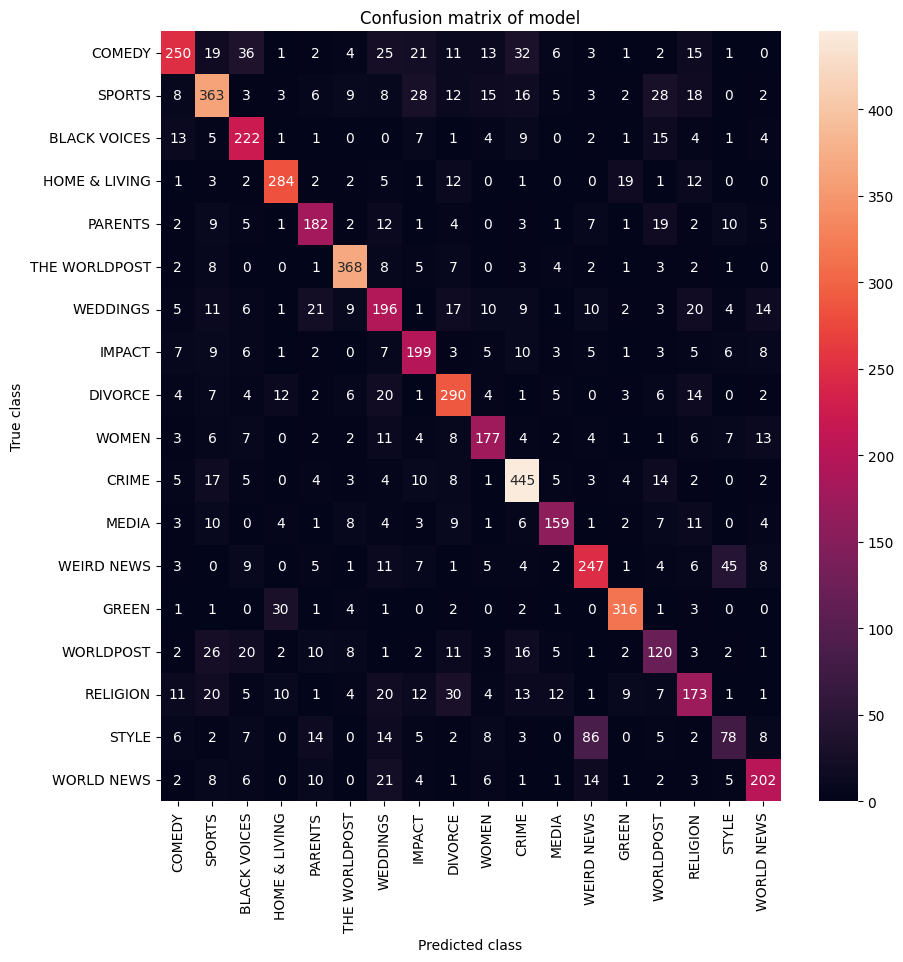

In [30]:
y_pred = prediction(X_test)
print(classification_report(np.asarray(y_test),np.asarray( y_pred)))
cf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=classes,
                      yticklabels=classes,
                      annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')